In [47]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from transformers import BertTokenizer
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

In [48]:
df = pd.read_csv("hf://datasets/owaiskha9654/PubMed_MultiLabel_Text_Classification_Dataset_MeSH/PubMed Multi Label Text Classification Dataset Processed.csv")
df = df.sample(n=1000, random_state=42) # for testing purposes

In [49]:
df.head()

,Title,abstractText,meshMajor,pmid,meshid,meshroot,A,B,C,D,E,F,G,H,I,J,L,M,N,Z
33553,Vertical trauma: injuries to patients who fall...,We reviewed the patterns of injuries sustained...,"['Accidental Falls', 'Accidents', 'Adolescent'...",2916780,"[['N06.850.135.122'], ['N06.850.135'], ['M01.0...","['Health Care [N]', 'Named Groups [M]', 'Organ...",0,1,1,0,0,1,0,0,1,0,0,1,1,0
9427,The influence of bilateral sagittal split ramu...,The effect of orthodontic-surgical treatment o...,"['Adolescent', 'Adult', 'Chin', 'Esthetics, De...",24946129,"[['M01.060.057'], ['M01.060.116'], ['A01.456.5...","['Named Groups [M]', 'Anatomy [A]', 'Analytica...",1,1,0,0,1,0,0,0,0,0,0,1,1,0
199,Altered metabolic incorporation of fucose and ...,Sciatic nerves of 25-week-old genetically diab...,"['Animals', 'Carbon Radioisotopes', 'Diabetes ...",6888648,"[['B01.050'], ['D01.268.150.075.328', 'D01.496...","['Organisms [B]', 'Chemicals and Drugs [D]', '...",1,1,1,1,1,0,0,0,0,0,0,0,0,0
12447,Higher temperatures increase developmental rat...,Effects of temperature on development of Raja ...,"['Adaptation, Biological', 'Analysis of Varian...",31049955,"[['G16.012'], ['E05.318.740.150', 'N05.715.360...","['Phenomena and Processes [G]', 'Analytical, D...",0,1,0,0,1,0,1,0,0,0,0,0,1,1
39489,MR imaging of the flexed knee: comparison to t...,The aim of this study was to obtain MR images ...,"['Adolescent', 'Adult', 'Arthroscopy', 'Female...",11097414,"[['M01.060.057'], ['M01.060.116'], ['E01.370.3...","['Named Groups [M]', 'Analytical, Diagnostic a...",1,1,1,0,1,0,1,0,0,0,0,1,1,0


In [50]:
#choose a category of interest
curU = 'A'
#we now want a df of labels (curU) and merge abstractText and Title, call this column 'text', and tokenize all text using BERT
df = df[['abstractText', 'Title', curU]]
df['text'] = df['Title'] + ' ' + df['abstractText']
df = df[['text', curU]]
df = df.dropna()
df = df.reset_index(drop=True)
df.head()


,text,A
0,Vertical trauma: injuries to patients who fall...,0
1,The influence of bilateral sagittal split ramu...,1
2,Altered metabolic incorporation of fucose and ...,1
3,Higher temperatures increase developmental rat...,0
4,MR imaging of the flexed knee: comparison to t...,1


In [34]:
#tokenize text
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
df['text'] = df['text'].apply(lambda x: tokenizer.encode(x, add_special_tokens=True))
df.head()

#print the datatype of the text column
print(type(df['text'][0]))


Token indices sequence length is longer than the specified maximum sequence length for this model (751 > 512). Running this sequence through the model will result in indexing errors


<class 'list'>


In [35]:
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn

# Custom Dataset class
class TextDataset(Dataset):
    def __init__(self, dataframe):
        self.texts = dataframe['text'].values
        self.labels = dataframe['A'].values

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = torch.tensor(self.texts[idx], dtype=torch.long)  # Convert to tensor
        label = torch.tensor(self.labels[idx], dtype=torch.long)  # Convert to tensor
        return text, label

# Instantiate the dataset and dataloader
dataset = TextDataset(df)

# Define a collate function for padding
from torch.nn.utils.rnn import pad_sequence

def collate_fn(batch):
    texts, labels = zip(*batch)
    texts_padded = pad_sequence(texts, batch_first=True, padding_value=0)  # Pad texts
    labels = torch.stack(labels)  # Stack labels
    return texts_padded, labels

dataloader = DataLoader(dataset, batch_size=32, shuffle=True, collate_fn=collate_fn)


In [44]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class TextCNN(nn.Module):
    def __init__(self, vocab_size, embedding_dim, intermediate_dims, kernel_sizes, num_filters):
        super(TextCNN, self).__init__()
        # Embedding layer
        self.embedding = nn.Embedding(vocab_size, embedding_dim)

        # Convolutional layers with kernel sizes
        self.convs = nn.ModuleList([
            nn.Conv1d(in_channels=embedding_dim, out_channels=num_filters, kernel_size=k)
            for k in kernel_sizes
        ])

        # Fully connected layers to reduce dimensions
        self.fc1 = nn.Linear(num_filters * len(kernel_sizes), intermediate_dims[0])  # From conv outputs
        self.fc2 = nn.Linear(intermediate_dims[0], intermediate_dims[1])  # Reduce further
        self.fc3 = nn.Linear(intermediate_dims[1], intermediate_dims[2])  # Final output for binary prediction

        # Dropout for regularization
        self.dropout = nn.Dropout(0.5)

        # Non-linearity (sigmoid)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        # Embed the input and permute for Conv1d
        x = self.embedding(x).permute(0, 2, 1)  # [batch_size, embedding_dim, seq_len]

        # Apply convolutional layers and global max-pooling
        conv_outs = [F.relu(conv(x)).max(dim=2)[0] for conv in self.convs]
        x = torch.cat(conv_outs, dim=1)  # Concatenate along the channel dimension

        # Apply fully connected layers with non-linearity
        x = self.fc1(x)
        x = self.sigmoid(x)
        x = self.fc2(x)
        x = self.sigmoid(x)
        x = self.fc3(x)

        return x

# Hyperparameters
vocab_size = tokenizer.vocab_size  # Use tokenizer's vocab size (e.g., 30522)
embedding_dim = 128
intermediate_dims = [8, 4, 1]  # Progressively reduce dimensions
kernel_sizes = [3, 4, 5]  # Common kernel sizes for text
num_filters = 100  # Number of filters per kernel size

# Instantiate the model
model = TextCNN(vocab_size, embedding_dim, intermediate_dims, kernel_sizes, num_filters)

# Print the model summary
print(model)



import torch.optim as optim

# Define criterion and optimizer
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Train the model
def train_model(model, dataloader, criterion, optimizer, epochs=5):
    model.train()
    for epoch in range(epochs):
        total_loss = 0
        for texts, labels in dataloader:
            labels = labels.float().unsqueeze(1)  # Adjust labels for BCEWithLogitsLoss
            optimizer.zero_grad()
            outputs = model(texts)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        print(f"Epoch {epoch+1}, Loss: {total_loss / len(dataloader)}")

train_model(model, dataloader, criterion, optimizer, epochs=5)



TextCNN(
  (embedding): Embedding(30522, 128)
  (convs): ModuleList(
    (0): Conv1d(128, 100, kernel_size=(3,), stride=(1,))
    (1): Conv1d(128, 100, kernel_size=(4,), stride=(1,))
    (2): Conv1d(128, 100, kernel_size=(5,), stride=(1,))
  )
  (fc1): Linear(in_features=300, out_features=8, bias=True)
  (fc2): Linear(in_features=8, out_features=4, bias=True)
  (fc3): Linear(in_features=4, out_features=1, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (sigmoid): Sigmoid()
)
Epoch 1, Loss: 0.7288973089307547
Epoch 2, Loss: 0.7140036299824715
Epoch 3, Loss: 0.7088257800787687
Epoch 4, Loss: 0.7025141324847937
Epoch 5, Loss: 0.6979350354522467


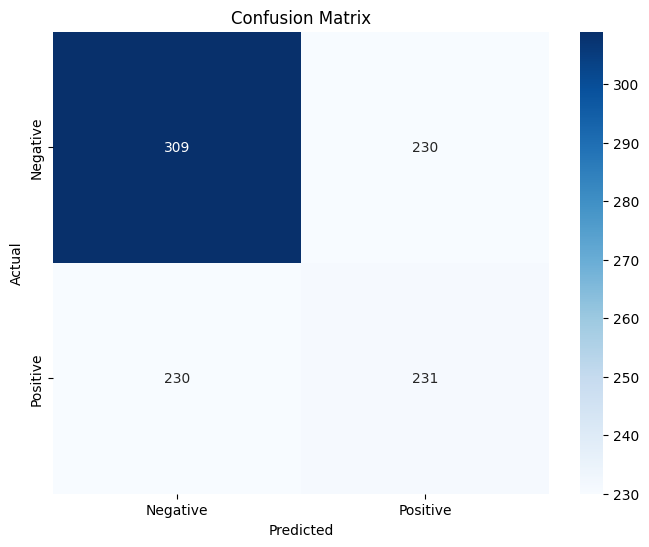

              precision    recall  f1-score   support

           0       0.57      0.57      0.57       539
           1       0.50      0.50      0.50       461

    accuracy                           0.54      1000
   macro avg       0.54      0.54      0.54      1000
weighted avg       0.54      0.54      0.54      1000

Accuracy: 0.54


In [45]:
# visualize the model
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(y_true, y_pred, labels):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', xticklabels=labels, yticklabels=labels, cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()

# Evaluate the model
def evaluate_model(model, dataloader):
    model.eval()
    y_true = []
    y_pred = []
    with torch.no_grad():
        for texts, labels in dataloader:
            outputs = model(texts)
            _, predicted = torch.max(outputs, 1)
            y_true.extend(labels.tolist())
            y_pred.extend(predicted.tolist())
    return y_true

# Get the true and predicted labels
y_true = evaluate_model(model, dataloader)
y_pred = evaluate_model(model, dataloader)

# Plot the confusion matrix
plot_confusion_matrix(y_true, y_pred, ['Negative', 'Positive'])

# Print the classification report
print(classification_report(y_true, y_pred))

# Calculate the accuracy
accuracy = accuracy_score(y_true, y_pred)

print(f"Accuracy: {accuracy:.2f}")





In [ ]:
#### OLD CODE ####
class TextCNN(nn.Module):
    def __init__(self, vocab_size, embedding_dim, num_classes, kernel_sizes, num_filters):
        super(TextCNN, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.convs = nn.ModuleList([
            nn.Conv1d(in_channels=embedding_dim, out_channels=num_filters, kernel_size=k)
            for k in kernel_sizes
        ])
        self.fc = nn.Linear(num_filters * len(kernel_sizes), num_classes)
        self.dropout = nn.Dropout(0.5)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.embedding(x).permute(0, 2, 1)  # [batch_size, embedding_dim, seq_len]
        conv_outs = [self.relu(conv(x)).max(dim=2)[0] for conv in self.convs]  # Global max-pooling
        x = torch.cat(conv_outs, dim=1)  # Concatenate along the channel dimension
        x = self.dropout(x)
        x = self.fc(x)
        return x

# Hyperparameters
vocab_size = tokenizer.vocab_size # Adjust based on your tokenizer
embedding_dim = 128
num_classes = 2  # Binary classification
kernel_sizes = [3, 4, 5]
num_filters = 100

# Instantiate the model
model = TextCNN(vocab_size, embedding_dim, num_classes, kernel_sizes, num_filters)

# Print the model summary
print(model)


import torch.optim as optim

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
def train_model(model, dataloader, criterion, optimizer, epochs=5):
    model.train()
    for epoch in range(epochs):
        total_loss = 0
        for texts, labels in dataloader:
            optimizer.zero_grad()
            outputs = model(texts)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        print(f"Epoch {epoch+1}, Loss: {total_loss / len(dataloader)}")

# Train the model
train_model(model, dataloader, criterion, optimizer, epochs=5)

